# CS4240 Deep Learning - Assignment 6

*These lab assignments are new in the CS4240 Deep Learning course. We'd like to hear what you think!*

*Please post any feedback you have on [Brightspace](https://brightspace.tudelft.nl/d2l/le/280420/discussions/topics/48829/View). Thanks!*

To start working on the assignment in Colab, save a copy on your Google Drive (`File` $\rightarrow$ `Save a copy in Drive`).

To work on the assignments locally, configure your conda environment (see instructions on Brightspace) and download this assignment as an IPython Notebook (`File` $\rightarrow$ `Download .ipynb`).

## Introduction

In this assignment you will learn about Recurrent Neural Networks (RNNs), Gated Recurrent Units (GRUs) and Long Short-Term Memmories (LSTMs). It dives into implementation of these as well and you'll train them on the MNIST-1D dataset. 

**Prerequisites:**
* Completion of previous assignments (1-5).
* Basic knowledge of Python and Numpy. </br> Recommended tutorial for Python and Numpy [here](https://cs231n.github.io/python-numpy-tutorial/).
* We recommend you to have a look at [this excellent tutorial on PyTorch Tensors](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).

**Learning objectives:**
* Understanding the idea and versatility of networks that are able to process (and potentially output) sequential data.
* Understanding the concepts of RNNs, GRUs and LSTMs.
* Implementing and training RNNs - from scratch
* Implementing and using GRUs and LSTMs in training - pytorch modules

---

When answering coding questions make sure to write your own code within the designated part of the code block as illustrated here:
```python 
#############################################################################
#                       TODO: Implement function x                          #
#############################################################################
# Replace "pass" statement with your code
pass
#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################
```

In [ ]:
# Setup
import os
import math
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models

from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

#Additional Setup to use Tensorboard
!pip install -q tensorflow
%load_ext tensorboard

#Additional Setup for MNIST-1D
!git clone https://github.com/greydanus/mnist1d
import mnist1d
from mnist1d.data import get_templates, get_dataset_args, get_dataset
from mnist1d.utils import set_seed, plot_signals, ObjectView, from_pickle

##A6.1 Recurrent Neural Networks

* Talk about relevance of networks that are able to learn from (variable-length) sequential data and potentially to output in similar fashion.
* How do RNNs work? Show unfoldment of the computational graph and why it preserves the exact amount of learnable parameters while having the ability to cope with sequences of arbitrary length.
* Implement RNNs
* Train RNNs on MNIST-1D

### Sequential data with varying length

Until now, we have worked with data for which all samples have exactly the same input sizes or have the ability to mold the inputs (as pre-processing step) in similar sized objects without necessarily losing important information (e.g. resizing or cropping images). In many tasks though, inputs are of inherently different sizes without the possibility to be shrinked or expanded without losing essential embedded information in the process. As an example, think about a machine that is asked to assign a detailed description (input) to a specific category (output). In order to clarify the problem, two descriptions are provided that should be categorized as "house".

* 'Place in which people live.'
* 'Building that provides shelter to a family, often referred to as "home".'

Here, the input sizes (= the amount of characters in the sentence) differ by a lot. This task is therefor impossible for machines that are not able to cope with inputs of varying length. Consequently, the space of problems these machines are able to solve is highly limited as the majority of problems in this world have to deal with those variable input sizes. In analogy to varying input lengths, the same convincing argument could be used to argue that machines having the potential to produce different sized outputs are even increasing the amount of learnable problems. Think of machines that are asked to translate between two different languages (type of sequence-to-sequence learning). In this case machines must be equiped with the ability to produce length-varying outputs. These networks exist and one of them is the recurrent neural network (RNN).

### RNNs: updating a *fixed amount* of hidden states through reccurence

a RNN consists of a hidden part that updates its internal hidden states recursively throughout the feedforward pass. The amount of recurrences depends solely on the length of the sequence. In this way, whatever you choose as (recurrence) function, the amount of hidden states is preserved independent of the sequence length. Mathematically this recurrence can be seen as a dynamical system strictly formulated as

$$ \mathbf{h}^{(t)} = f \left( \mathbf{h}^{(t-1)}, \mathbf{x}^{(t)} \right) $$

in which $\mathbf{h}$ is the hidden state, $\mathbf{x}$ the input and $f$ an arbitrary function. Most importantly, $t$ denotes how far you are in the sequence. If we choose the map between the hidden state at time $t-1$ and $t$ and the hidden state and the input to be linear, we arrive at

$$ \mathbf{h}^{(t)} = W_{hh} \mathbf{h}^{(t-1)} + W_{hx}\mathbf{x}^{(t)} + \mathbf{b}.$$

Here, $W_{hh}$ and $W_{hx}$ are the weights and $\mathbf{b}$ the bias term. Please note that $\mathbf{x}^{(t)}$ must have the same size at every iteration (which is perfectly possible if your sequence is partitioned in equivalently sized chunks of data). As we did before, we can make the map non-linear through the addition of an activation function:

$$ \mathbf{h}^{(t)} = \phi \left( W_{hh} \mathbf{h}^{(t-1)} + W_{hx}\mathbf{x}^{(t)} + \mathbf{b} \right)$$

for which the $\tanh$ function is often chosen in RNNs. So far we haven't yet introduced how the output is generated. There is several ways, but in its most general form the network generates an output at every step as

$$ \mathbf{o}^{(t)} = \psi \left( W_{yh} \mathbf{h}^{(t)} + \mathbf{c} \right)$$

which can be regarded as an extra fully-connected layer on top of the hidden state. Please find out for yourself how the types given in the lecture (one-to-many, many-to-one and many-to-many) relate and change the equations above. An example of *language modelling* is given in the figure below.

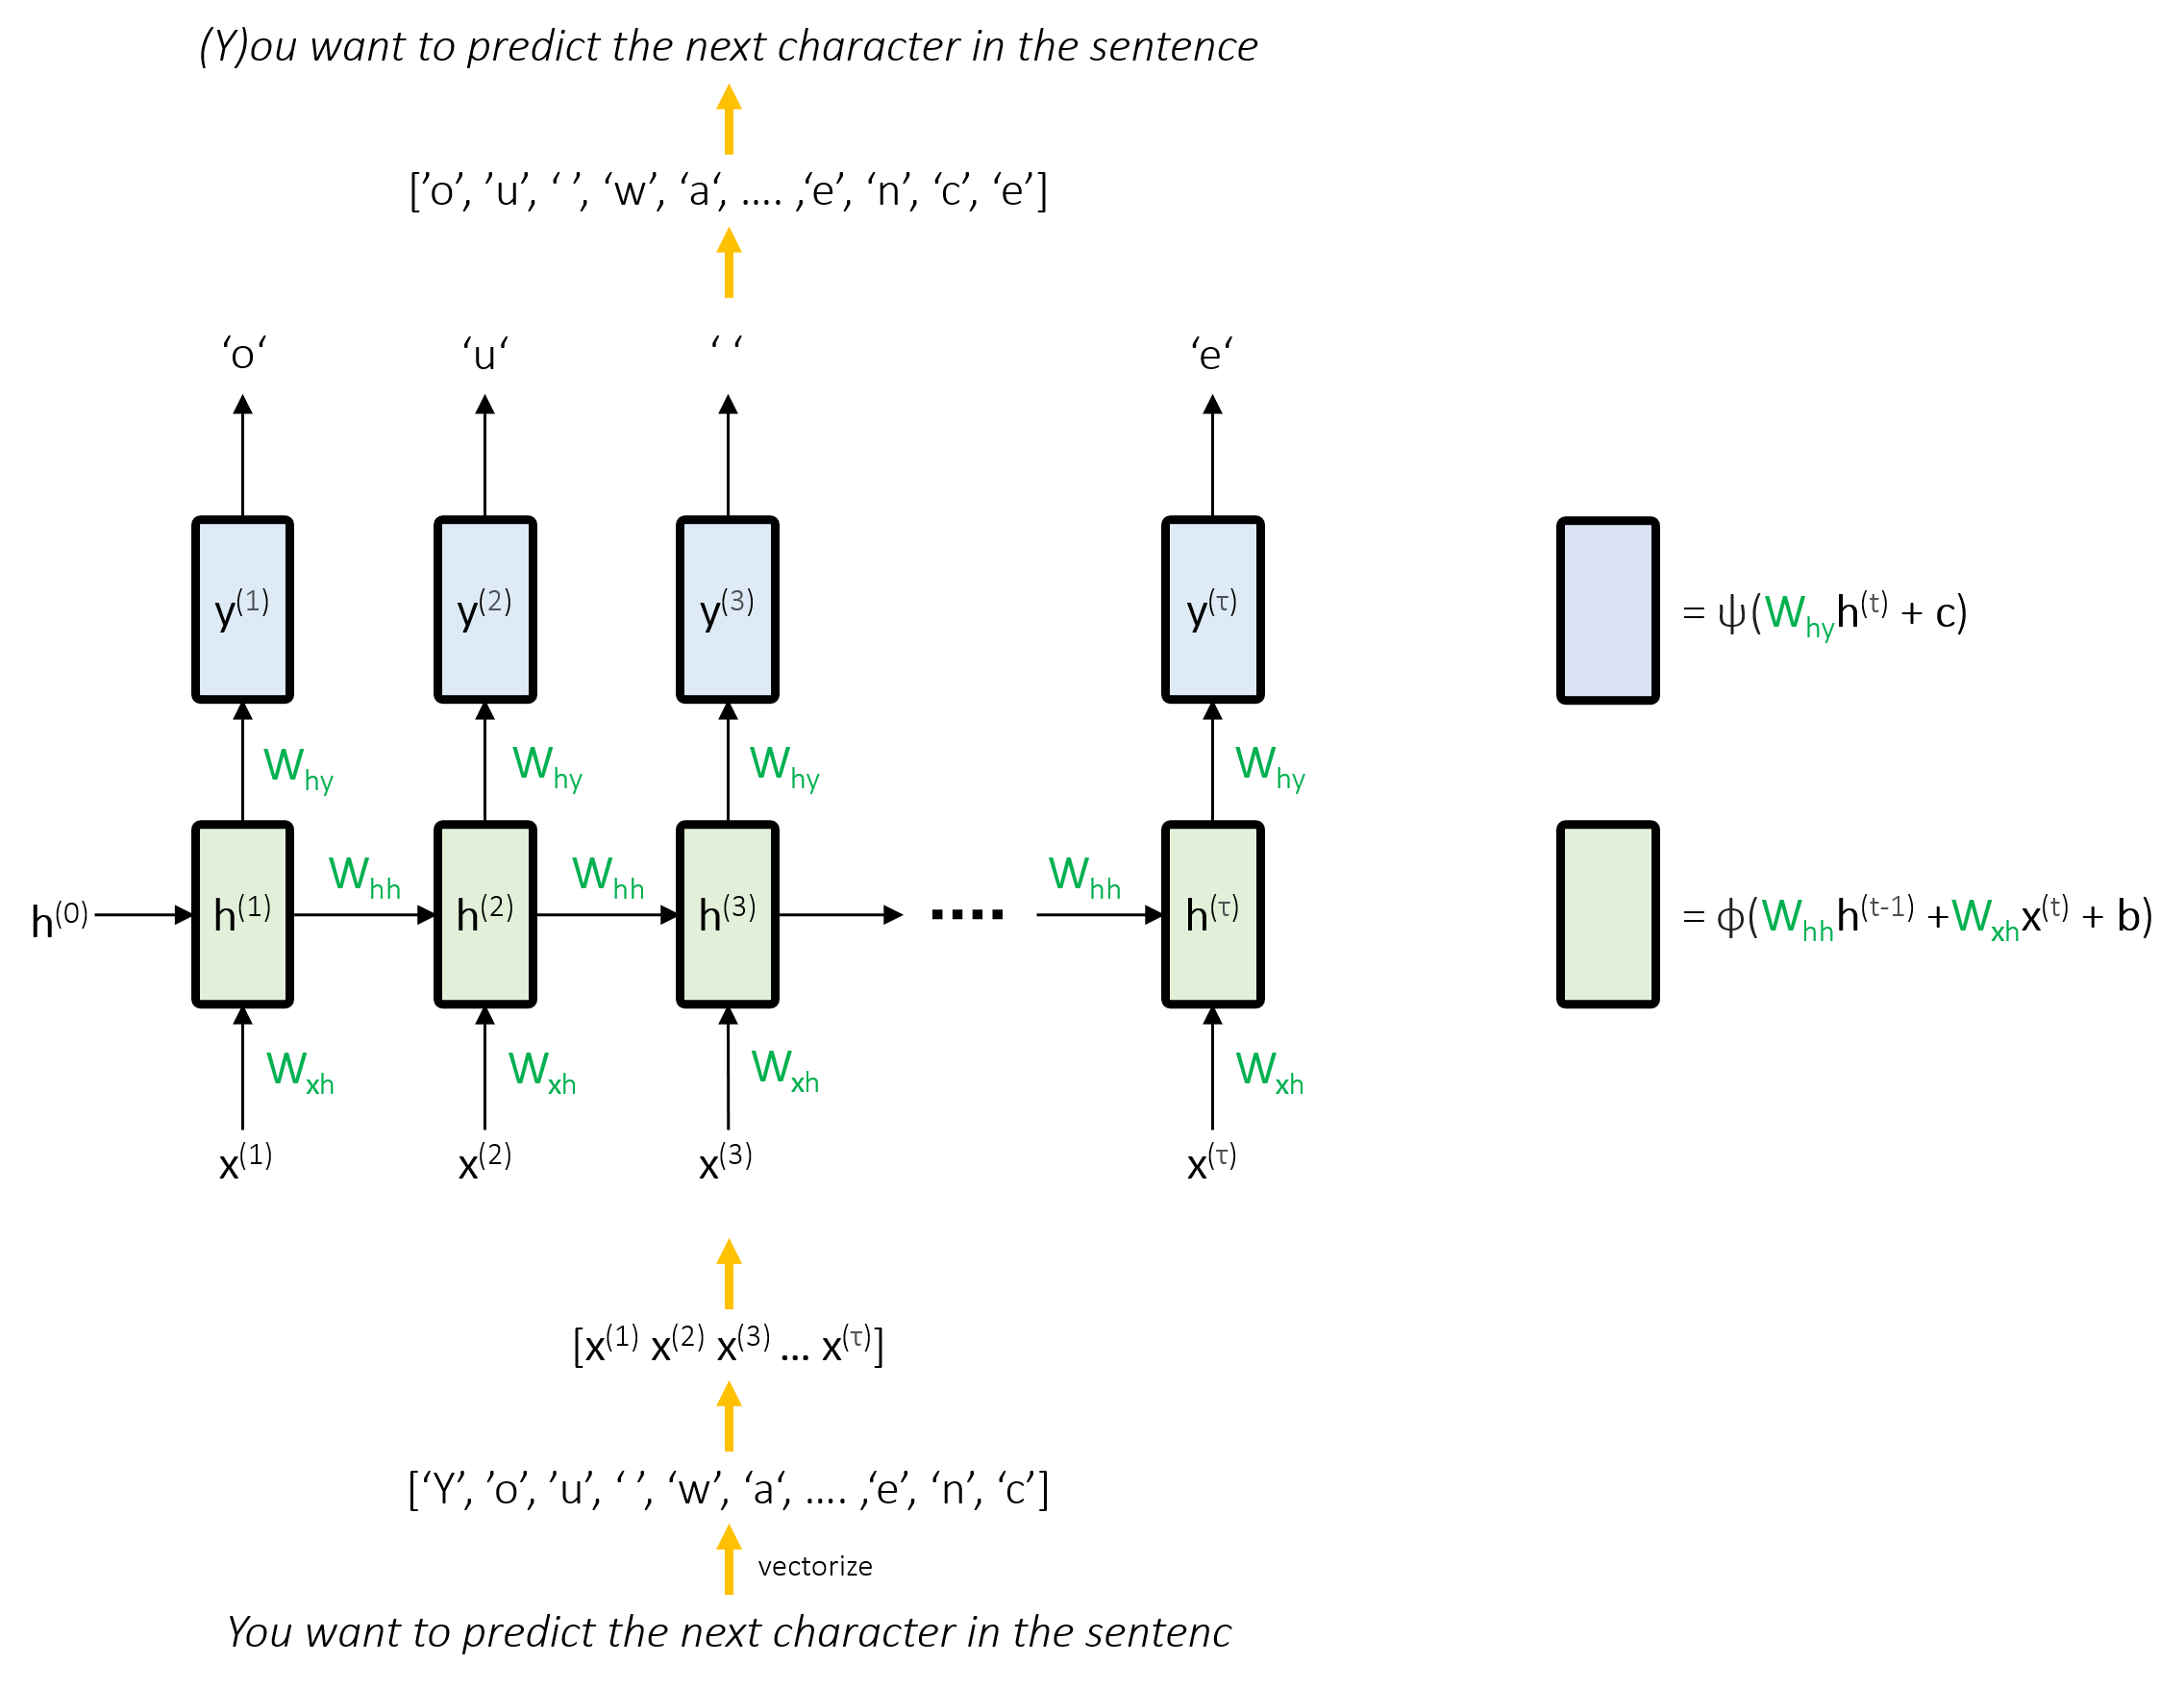

In case of the MNIST-1D dataset we provide sequences as inputs and ask for a single class as output. The output is therefor a sum over all *sequential* outputs

$$ \begin{aligned}
\mathbf{o} &= \frac{1}{\tau} \sum_{t=1}^{\tau} \mathbf{o}^{(t)} \\
 &= \psi \left( \frac{1}{\tau} \sum_{t=1}^{\tau} W_{yh} \mathbf{h}^{(t)} + \mathbf{c} \right).
\end{aligned}$$

in which $\tau$ is the length of the sequence. The figure below provides a visual interpretation.

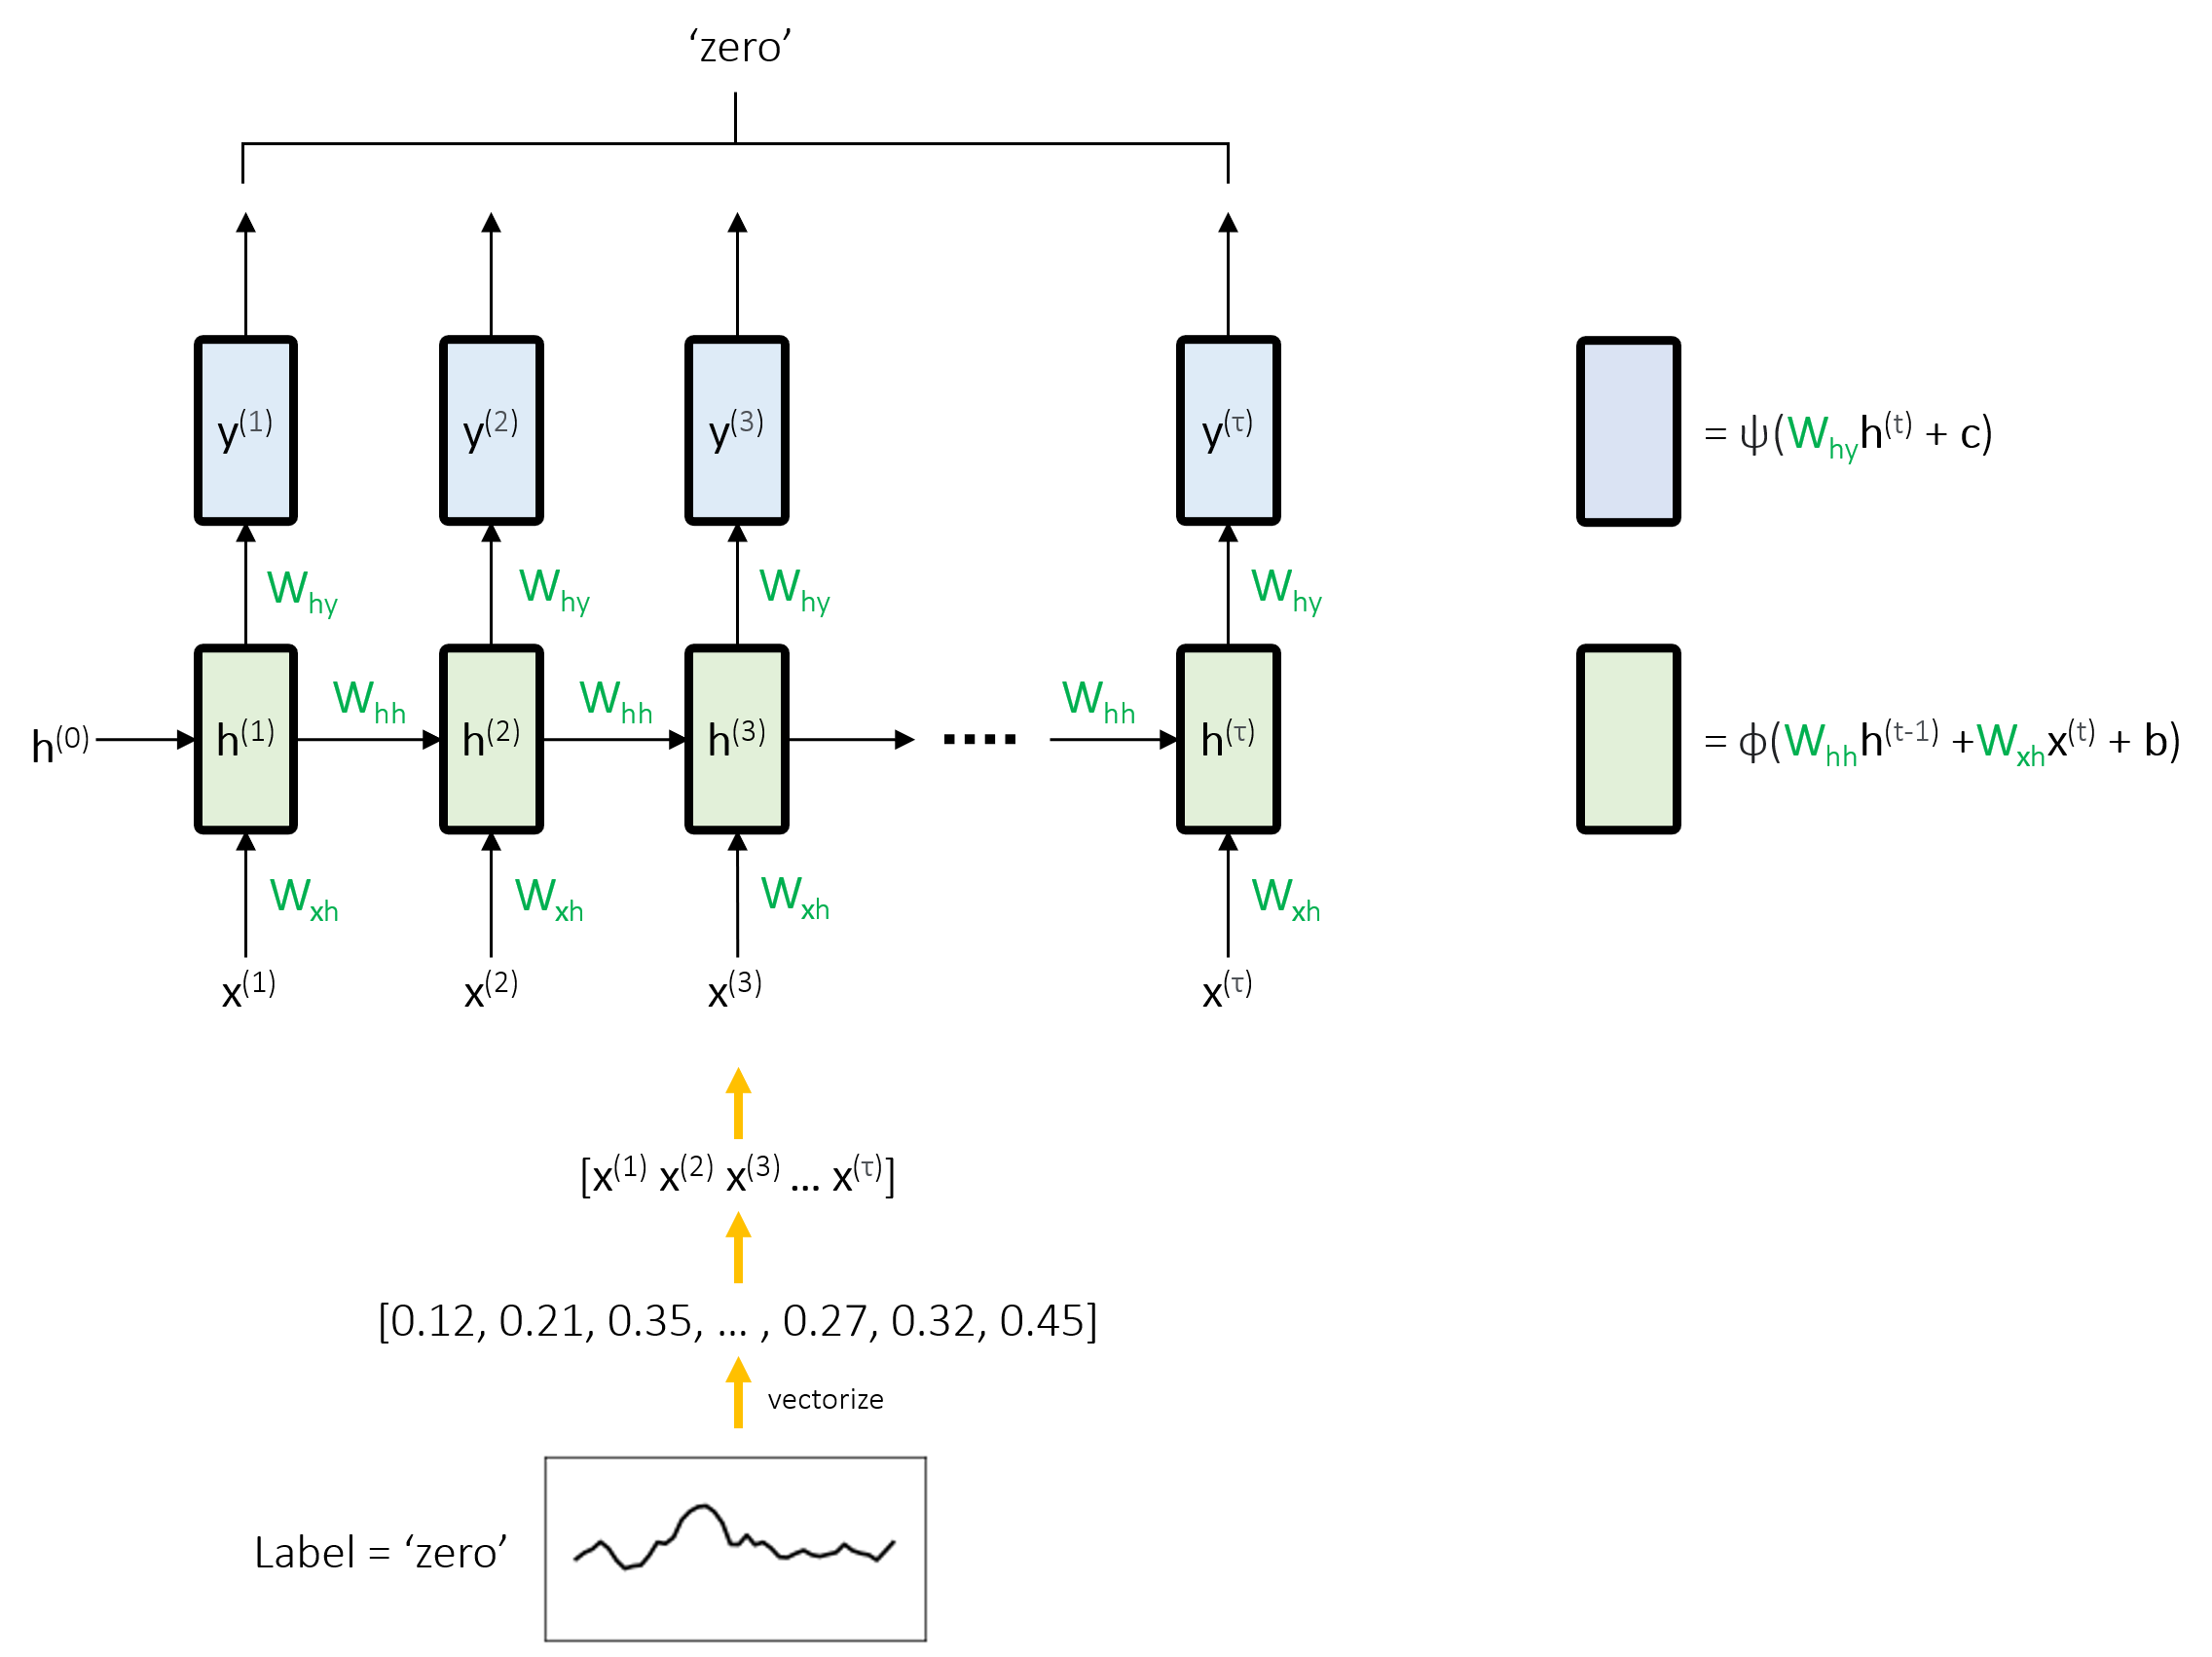


### Implementing the *Vanilla* RNN

To be honest, the specific RNN spoken of so far is called the *Vanilla* or *Elman* RNN which is regarded the most simple form of deploying recurrences (single layer, no memory/forget gates and/or no complex structures). You will learn how to implement this Vanilla RNN for classifying handwritten digits (see second visual interpretation). Please complete the model below. 

**Be aware that you will couple the fully connected [output] layer in a later stage.**

Hint: think about all the architectural hyperparameters and especially sizes of the input, hidden states, weights and outputs. 

In [ ]:
class VanillaRNN(nn.Module):
    """
    Vanilla recurrent neural network (a.k.a. Elman RNN)
    """
    def __init__(self, input_size, hidden_size):
        super(VanillaRNN, self).__init__()

        self.hidden_size = hidden_size

        # Input to hidden weights
        self.weight_xh = None

        # Hidden to hidden biases
        self.weight_hh = None

        # Input to hidden biases
        self.bias_xh = None

        # Hidden to hidden biases
        self.bias_hh = None

        ########################################################################
        #    TODO: Create weight and bias tensors with given name above with   #
        #                             correct sizes.                           #
        ########################################################################

        pass

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Initialize parameters
        self.reset_params()


    def reset_params(self):
        """
        Reset network parameters. Applies `init_params` to all parameters.
        """

        std = 1.0 / math.sqrt(self.hidden_size)
        self.weight_xh.data.uniform_(-std, std)
        self.weight_hh.data.uniform_(-std, std)
        self.bias_xh.data.uniform_(-std, std)
        self.bias_hh.data.uniform_(-std, std)


    def forward(self, x):
        """
        Args:
            x: input with shape (N, T, D) where N is number of samples, T is
                number of timestep and D is input size which must be equal to
                self.input_size.

        Returns:
            y: output with a shape of (N, T, H) where H is hidden size
        """

        # Transpose input for efficient vectorized calculation. After transposing
        # the input will have (T, N, D).
        x = x.transpose(0, 1)

        # Unpack dimensions
        T, N = x.shape[0], x.shape[1]

        # Initialize hidden states to zero. There will be one hidden state for
        # each input, so it will have shape of (N, H)
        h0 = torch.zeros(N, self.hidden_size, device=x.device)

        # Define a list to store outputs. We will then stack them.
        y = []

        ########################################################################
        #             TODO: Implement forward pass of Vanilla RNN              #
        ########################################################################

        pass

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################
        
        # Stack the outputs. After this operation, output will have shape of
        # (T, N, H)
        y = torch.stack(y)

        # Switch time and batch dimension, (T, N, H) -> (N, T, H)
        y = y.transpose(0, 1)

        return y

We will now test this RNN on implementability. Again: what are `N`, `T` and `D`? How do input and output tensors relate? Does the amount of weights depend on input and output and sizes? And more specifically, do all weight blocks ($W_{hx}$, $W_{hh}$ etc.) change necessarily with different input and output sizes? Can you come up with the exact amount of parameters (total) if the input size, output size and amount of hidden states are given?

In [ ]:
torch.manual_seed(123)

N, T, D = 2, 3, 4

x = torch.tensor([[[0.7957, 0.5273, 0.3984, 0.2958],
         [0.3043, 0.4366, 0.6209, 0.4625],
         [0.4545, 0.8004, 0.9374, 0.6986]],

        [[0.4338, 0.7891, 0.1068, 0.8820],
         [0.0045, 0.7733, 0.6096, 0.7807],
         [0.0209, 0.7052, 0.9621, 0.5020]]])

y_expected = torch.tensor([[[-0.1970, -0.0668, -0.0769,  0.5907, -0.0841,  0.2742, -0.6842,
           0.0232, -0.5910,  0.0012],
         [-0.0470,  0.2382, -0.2181,  0.6580,  0.0175,  0.3684, -0.5890,
          -0.2707, -0.6052, -0.2056],
         [ 0.0395,  0.3300, -0.2654,  0.7699, -0.0464,  0.3388, -0.7173,
          -0.0602, -0.5534, -0.3371]],

        [[-0.0902,  0.0316, -0.0349,  0.5173,  0.1766,  0.1269, -0.7318,
           0.0493, -0.6808,  0.0731],
         [ 0.0899,  0.2755, -0.2333,  0.6312,  0.0653,  0.2133, -0.7234,
          -0.0952, -0.6183, -0.2029],
         [ 0.0991,  0.2310, -0.1834,  0.7653,  0.0268,  0.2558, -0.6915,
           0.0239, -0.4378, -0.3501]]])

model = VanillaRNN(D, 10)
y = model(x)

print('Output check:', torch.allclose(y, y_expected, atol=1e-4))

### Training RNNs on MNIST-1D
You are ready to train the RNN on the MNIST-1D data set. The following code block is directly copied of previous assignment and loads and structures the data. 

In [ ]:
# Load dataset
args = get_dataset_args()
data = get_dataset(args, path='./mnist1d_data.pkl', download=True) # This is the default setting

# Set the batch size for training & testing
b_size = 100

# Convert 1D MNIST data to pytorch tensors
tensors_train = torch.Tensor(data['x']), torch.Tensor(data['y']).long()
tensors_test = torch.Tensor(data['x_test']),torch.Tensor(data['y_test']).long()

# Create training set and test set from tensors
train_set = TensorDataset(*tensors_train)
test_set = TensorDataset(*tensors_test)

# Create dataloaders from the training and test set for easier iteration over the data
train_loader = DataLoader(train_set, batch_size=b_size)
test_loader = DataLoader(test_set, batch_size=b_size)

# Get some data and check for dimensions
input, label = next(iter(train_loader))

# Check whether the data has the right dimensions
assert(input.shape == torch.Size([b_size, 40]))
assert(label.shape == torch.Size([b_size]))

# Display samples from dataset
templates = get_templates()
fig = plot_signals(templates['x'], templates['t'], labels=templates['y'],
                   args=get_dataset_args(), ratio=2.2, do_transform=True)

In similar fasion as in the previous assignment, we create several *utility* functions that make life easy when defining a main code block to run from. The following utility functions are created:

1. `train`: trains and updates the model. Needs a training data set, specific model, optimizer and loss function as inputs. This training procedure updates for 1 epoch only (see `run` later on).
2. `test`: tests a model on a specific data set (can be train, validation and/or testset). Needs the loader, model and loss function as inputs.
3. `run`: To make playing with different models more straightforward, we provided a function in which you can chose across several types of RNN's: `vanilla`, `gru` or `lstm`. GRU and LSTM will be defined later. The training procedure is consistent with previous assignments and makes use of `train` and `test`. It needs as inputs the amount of epochs and hidden units.

Please be aware that the overarching model (including the fully connected output layer) is defined in `run` that consecutively 1. unflattens the input (to create chunks of data that can be sequentially fed into the network) 2. feedforwards through the RNN 3. flattens the output (=final hidden state) back again and 4. couples those flattened hidden states to the *real* outputs using a fully connected layer.

In [ ]:
def train(train_loader, model, optimizer, criterion, device):
    """
    Trains network for one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        model: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).
    """
  
    avg_loss = 0
    correct = 0
    total = 0

    # Iterate through batches
    for i, data in enumerate(train_loader):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move data to target device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Keep track of loss and accuracy
        avg_loss += loss
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return avg_loss / len(train_loader), 100 * correct / total


def test(test_loader, model, criterion, device):
    """
    Evaluates network in batches.

    Args:
        test_loader: Data loader for test set.
        model: Neural network model.
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0
    correct = 0
    total = 0
    
    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():
        # Iterate through batches
        for data in test_loader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Move data to target device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Keep track of loss and accuracy
            avg_loss += loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return avg_loss / len(test_loader), 100 * correct / total


def run(rnn_type, epochs=100, hidden_size=10):
    """
    Run a test on MNIST-1D

    Args:
        rnn_type: can be either vanilla, gru or lstm
        epochs: number of epochs to run
        hidden_size: dimension of hidden state of rnn cell
    """
    # Create a writer to write to Tensorboard
    writer = SummaryWriter()

    if rnn_type == 'vanilla':
        rnn = VanillaRNN(1, hidden_size)
    elif rnn_type == 'gru':
        rnn = GRU(1, hidden_size)
    elif rnn_type == 'lstm':
        rnn = LSTM(1, hidden_size)
    else:
        raise Error('Unknown RNN type: ' + rnn_type)

    # Create classifier model
    model = nn.Sequential(OrderedDict([
        ('reshape', nn.Unflatten(1, (40, 1))),
        ('rnn', rnn),
        ('flat', nn.Flatten()),
        ('classifier', nn.Linear(40 * hidden_size, 10))
    ]))

    # Create loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 1e-2, weight_decay=1e-3)

    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = model.to(device)

    for epoch in tqdm(range(epochs)):
        # Train on data
        train_loss, train_acc = train(train_loader,
                                      model,
                                      optimizer,
                                      criterion,
                                      device)

        # Test on data
        test_loss, test_acc = test(test_loader,
                                   model,
                                   criterion,
                                   device)

        # Write metrics to Tensorboard
        writer.add_scalars('Loss', {
            'Train_{}'.format(rnn_type): train_loss,
            'Test_{}'.format(rnn_type): test_loss
        }, epoch)
        writer.add_scalars('Accuracy', {
            'Train_{}'.format(rnn_type): train_acc,
            'Test_{}'.format(rnn_type): test_acc
        }, epoch)


    print('\nFinished.')
    writer.flush()
    writer.close()

To come back to the benefit of the (especially last) utility function, you only have to run the following (ONE) line!

In [ ]:
run('vanilla')

Again, we will inspect the results in tensorboard.

In [ ]:
# For Google Colab users only, local users run the next cell
# Run Tensorboard
%tensorboard --logdir runs/

In [ ]:
# For local users only
# Uncomment the last line
# run this cell once and wait for it to time out
# run this cell a second time and you should see the board

# %tensorboard --logdir runs/ --host localhost

In [ ]:
# To completely clean your tensorboard uncomment and run the following command.
# !rm -r runs

##A6.2 Gated Recurrent Units
Theoretically, long-term dependencies can be learned using the simple vanilla structure, but in practice they lack that ability mostly. This is due to the vanishment or explosion of gradients. The same reasoning holds for long sequences in RNNs as for many layers in neural networks we were already familiar with. The length of the input sequences determine the amount of sequential multiplications for which it is most likely that they lead to gradients that are either very small or very large (except for gradients being close to 1). This decay or explosion of information through layers has shown to have a negative impact on learning capability of a network.

We will introduce two types of RNNs that are more complex in their structure in which they embed the capability to learn long-term dependencies in a more profound and explicity way. The first is the **Gated Recurrent Unit**, or *GRU* which is a simpler but still dedicated version of what we will discuss in the next section, which is the **Long Short-Term Memory**, or *LSTM*.

The general idea of both is that the recurrent layer must somehow learn what *old information must be forgotton or kept* and what *new information must be added* to the current hidden state. That first property is carefully regulated with what is called the reset gate. The reset gate determines the slice of information in the ancestor hidden state that is suppressed and which is passed through. The *reset* signal is computed as

$$
\mathbf{r}^{(t)} = \sigma \left( W_{rh} \mathbf{h}^{(t-1)} + W_{rh} \mathbf{x}^{(t)} + \mathbf{b}_{r}\right).
$$

The first part of the new updated state is computed as the pointwise multiplication with the ancestor hidden state. The *update* gate determines what information should be added to the hidden state and is learned through

$$
\mathbf{z}^{(t)} = \sigma \left( W_{zh} \mathbf{h}^{(t-1)} + W_{zh} \mathbf{x}^{(t)} + \mathbf{b}_{z}\right)
$$

in which $\mathbf{z}$ is the *update* signal. Based on the reset gate we first compute the current *candidate* hidden state:

$$
\tilde{\mathbf{c}}^{(t)} = \tanh \left( W_{hh} \left( \mathbf{r}^{(t)} \odot \mathbf{h}^{(t-1)} \right) + W_{xh} \mathbf{x}^{(t)} + \mathbf{b}_{h}\right).
$$

Depending on what should be forgotten about the ancestor hidden state, the current hidden state is defined as

$$
\mathbf{h}^{(t)} = \underbrace{\mathbf{r}^{(t)} \odot \mathbf{h}^{(t-1)}}_{\text{resets or puts through}} + \underbrace{\left( \mathbf{1}- \mathbf{r}^{(t)} \right) \odot \mathbf{r}^{(t)}}_{\text{adds new information (or not)}}.
$$

A block diagram makes life easier to understand (see the scheme of a general GRU depicted below).

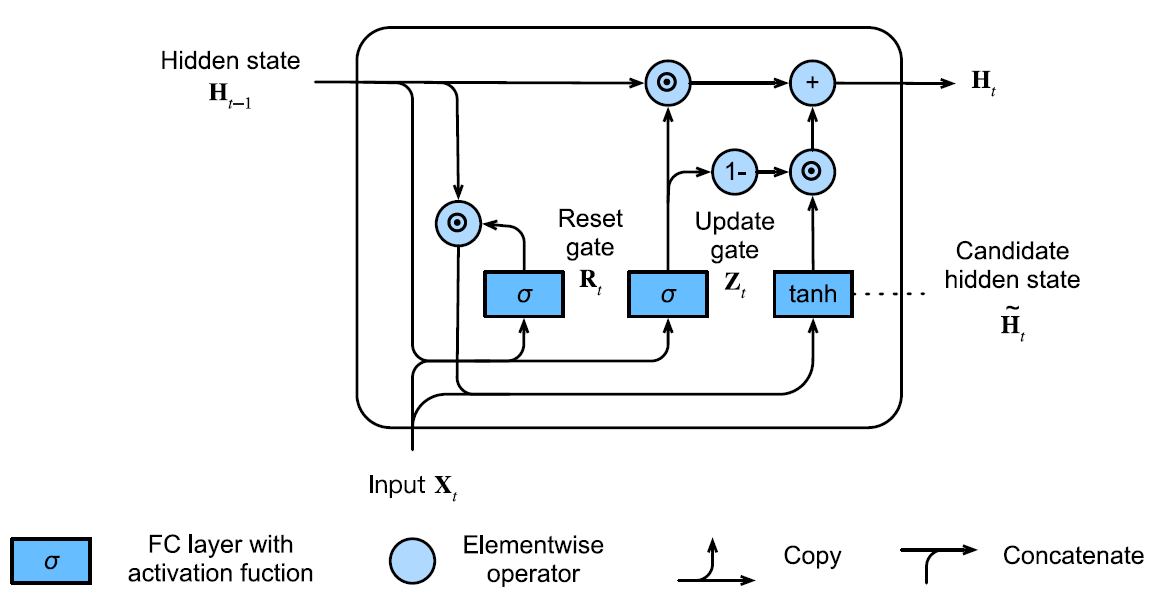

Please implement your own GRU in the code block below! 

Hint: for clarification, the formula's are given in the description of the class as well. (Be aware that they might be called slighly different.)

In [ ]:
class GRU(nn.Module):
    """
    Gated recurrent unit which has the following update rule:
        rt​ = σ(W_xr * ​xt​ + b_xr​ + W_hr * ​h(t−1) ​+ b_hr​)
        zt​ = σ(W_xz * ​xt​ + bxz​ + W_hz * ​h(t−1) ​+ b_hz​)
        nt​ = tanh(W_xn * ​xt ​+ b_xn ​+ rt​(W_hn * ​h(t−1) ​+ b_hn​))
        ht​ = (1 − zt​) ⊙ nt ​+ zt​ ⊙ h(t−1)​​
    """
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        # Input to hidden weights
        self.weight_xh = None

        # Hidden to hidden biases
        self.weight_hh = None

        # Input to hidden biases
        self.bias_xh = None

        # Hidden to hidden biases
        self.bias_hh = None

        ########################################################################
        #    TODO: Create weight and bias tensors with given name above with   #
        #                             correct sizes.                           #
        ########################################################################

        pass

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Initialize parameters
        self.reset_params()


    def reset_params(self):
        """
        Initialize network parameters.
        """

        std = 1.0 / math.sqrt(self.hidden_size)
        self.weight_xh.data.uniform_(-std, std)
        self.weight_hh.data.uniform_(-std, std)
        self.bias_xh.data.uniform_(-std, std)
        self.bias_hh.data.uniform_(-std, std)


    def forward(self, x):
        """
        Args:
            x: input with shape (N, T, D) where N is number of samples, T is
                number of timestep and D is input size which must be equal to
                self.input_size.

        Returns:
            y: output with a shape of (N, T, H) where H is hidden size
        """

        # Transpose input for efficient vectorized calculation. After transposing
        # the input will have (T, N, D).
        x = x.transpose(0, 1)

        # Unpack dimensions
        T, N, H = x.shape[0], x.shape[1], self.hidden_size

        # Initialize hidden states to zero. There will be one hidden state for
        # each input, so it will have shape of (N, H)
        h0 = torch.zeros(N, H, device=x.device)

        # Define a list to store outputs. We will then stack them.
        y = []

        ########################################################################
        #                 TODO: Implement forward pass of GRU                  #
        ########################################################################

        pass

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################
        
        # Stack the outputs. After this operation, output will have shape of
        # (T, N, H)
        y = torch.stack(y)
        
        # Switch time and batch dimension, (T, N, H) -> (N, T, H)
        y = y.transpose(0, 1)
        return y

Test GRU

In [ ]:
torch.manual_seed(123)

N, T, D = 2, 3, 4

x = torch.tensor([[[0.7957, 0.5273, 0.3984, 0.2958],
         [0.3043, 0.4366, 0.6209, 0.4625],
         [0.4545, 0.8004, 0.9374, 0.6986]],

        [[0.4338, 0.7891, 0.1068, 0.8820],
         [0.0045, 0.7733, 0.6096, 0.7807],
         [0.0209, 0.7052, 0.9621, 0.5020]]])

y_expected = torch.tensor([[[ 0.1931,  0.1542, -0.0479, -0.0970, -0.1372, -0.2287, -0.1640,
           0.0329,  0.0138, -0.0188],
         [ 0.2726,  0.1844, -0.0813, -0.2337, -0.2087, -0.3678, -0.2680,
           0.0144, -0.0137,  0.0491],
         [ 0.3761,  0.2024, -0.0414, -0.2505, -0.2948, -0.4843, -0.4014,
           0.0866,  0.0301,  0.0544]],

        [[ 0.1997,  0.1099, -0.0130, -0.1473, -0.1177, -0.2509, -0.2016,
           0.0021, -0.0220,  0.0533],
         [ 0.2857,  0.1486, -0.0474, -0.2790, -0.1991, -0.4168, -0.3185,
           0.0090, -0.0471,  0.1243],
         [ 0.3317,  0.1926, -0.0856, -0.3359, -0.2664, -0.5120, -0.3863,
           0.0435, -0.0440,  0.1394]]])

model = GRU(D, 10)
y = model(x)

print('Output check:', torch.allclose(y, y_expected, atol=1e-4))

Run MNIST-1D test

In [ ]:
run('gru')

To see the results, go back to [tensorboard](#scrollTo=XiZ-6Eg_5Mqt&line=1&uniqifier=1) and click the refresh button (image.png) in the top right corner.

What do you observe if comparing the learning curve? Is it performing better? And if yes, why? 

##A6.3 Long Short-Term Memories 

The LSTM is a slightly more abstract type of RNN but has many similarities compared to the GRU. It's working horses that learn what needs to be forgotten or kept, and that learn what should information to add in every update step are the same (only the naming is slightly inconsistent: instead of the reset gate, people mostly refer to the *forget* gate). The main differnce is the addition of a new state, refered to as the *cell* state. Instead of dependent regulation of hidden state, the cell state keeps track of the *state of the cell* and therefore inspects and controls what old information should be regarded irrelevant and thus thrown away, what should be throughputted and what new information should be added. 

In complete analogy to the GRU, the *forget* signal (which is later multiplied with the ancestor cell state) is computed as

$$
\mathbf{f}^{(t)} = \sigma \left( W_{fh} \mathbf{h}^{(t-1)} + W_{fh} \mathbf{x}^{(t)} + \mathbf{b}_{f}\right)
$$

in which again $W$ and $b$ comprise the learnable parameters. What new information should be added (or replaced) takes two steps. First we learn which part of the information will be either suppressed or highlighted (through the *information* signal, $\mathbf{i}$). This signal is than multiplied with the *candidate* cell state, $\tilde{\mathbf{c}}$, which is computed in similar fashion as before. The *update* signal is now computed as

$$
\begin{aligned}
\mathbf{z}^{(t)} 
&= \mathbf{i}^{(t)} \odot \tilde{\mathbf{c}}\\
&= \sigma \left( W_{ih} \mathbf{h}^{(t-1)} + W_{ih} \mathbf{x}^{(t)} + \mathbf{b}_{i}\right) \odot \tanh \left( W_{ch} \mathbf{h}^{(t-1)} + W_{ch} \mathbf{x}^{(t)} + \mathbf{b}_{c}\right).
\end{aligned}
$$

Combining both forget and update part results in the updated cell state as

$$
\mathbf{c}^{(t)} = \mathbf{f}^{(t)}  \odot \mathbf{c}^{(t-1)}  + \mathbf{z}^{(t)}.
$$

Were are not done yet. How do we update the hidden states based on information that resides in the cell state? What we output will be a filtered version of the cell state. This filter is again learned on the basis of the ancestor hidden state and curren input unit. It will not surprise you that the filter is defined as the following:

$$
\mathbf{h}^{(t)} = \sigma \left( W_{hh} \mathbf{h}^{(t-1)} + W_{hh} \mathbf{x}^{(t)} + \mathbf{b}_{h}\right)  \odot \tanh \left( \mathbf{c}^{(t)} \right).
$$

The scheme is again depicted below (observe that naming is not perfectly consistent: memory state instead of cell state)

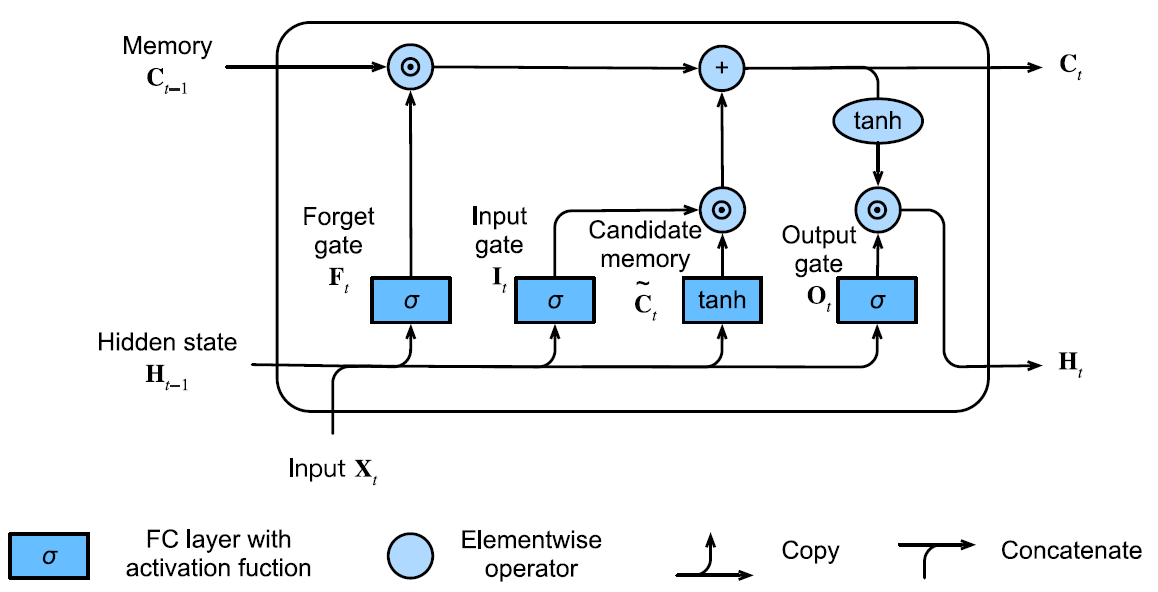

Please implement your own LSTM in the code block below.

In [ ]:
class LSTM(nn.Module):
    """
    Long short-term memory recurrent unit which has the following update rule:
        it ​= σ(W_xi * ​xt ​+ b_xi ​+ W_hi * ​h(t−1) ​+ b_hi​)
        ft​ = σ(W_xf * ​xt ​+ b_xf ​+ W_hf * ​h(t−1) ​+ b_hf​)
        gt ​= tanh(W_xg * ​xt ​+ b_xg ​+ W_hg * ​h(t−1) ​+ b_hg​)
        ot ​= σ(W_xo * ​xt ​+ b_xo​ + W_ho ​h(t−1) ​+ b_ho​)
        ct ​= ft​ ⊙ c(t−1) ​+ it ​⊙ gt​
        ht ​= ot​ ⊙ tanh(ct​)​
    """
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        # Input to hidden weights
        self.weight_xh = None

        # Hidden to hidden biases
        self.weight_hh = None

        # Input to hidden biases
        self.bias_xh = None

        # Hidden to hidden biases
        self.bias_hh = None

        ########################################################################
        #    TODO: Create weight and bias tensors with given name above with   #
        #                             correct sizes.                           #
        ########################################################################

        pass

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Initialize parameters
        self.reset_params()


    def reset_params(self):
        """
        Initialize network parameters.
        """

        std = 1.0 / math.sqrt(self.hidden_size)
        self.weight_xh.data.uniform_(-std, std)
        self.weight_hh.data.uniform_(-std, std)
        self.bias_xh.data.uniform_(-std, std)
        self.bias_hh.data.uniform_(-std, std)


    def forward(self, x):
        """
        Args:
            x: input with shape (N, T, D) where N is number of samples, T is
                number of timestep and D is input size which must be equal to
                self.input_size.

        Returns:
            y: output with a shape of (N, T, H) where H is hidden size
        """

        # Transpose input for efficient vectorized calculation. After transposing
        # the input will have (T, N, D).
        x = x.transpose(0, 1)

        # Unpack dimensions
        T, N, H = x.shape[0], x.shape[1], self.hidden_size

        # Initialize hidden and cell states to zero. There will be one hidden
        # and cell state for each input, so they will have shape of (N, H)
        h0 = torch.zeros(N, H, device=x.device)
        c0 = torch.zeros(N, H, device=x.device)
        
        # Define a list to store outputs. We will then stack them.
        y = []

        ########################################################################
        #                 TODO: Implement forward pass of LSTM                 #
        ########################################################################

        pass

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################
        
        # Stack the outputs. After this operation, output will have shape of
        # (T, N, H)
        y = torch.stack(y)

        # Switch time and batch dimension, (T, N, H) -> (N, T, H)
        y = y.transpose(0, 1)
        return y

Again, test your LSTM.

In [ ]:
torch.manual_seed(123)

N, T, D = 2, 3, 4

x = torch.tensor([[[0.7957, 0.5273, 0.3984, 0.2958],
         [0.3043, 0.4366, 0.6209, 0.4625],
         [0.4545, 0.8004, 0.9374, 0.6986]],

        [[0.4338, 0.7891, 0.1068, 0.8820],
         [0.0045, 0.7733, 0.6096, 0.7807],
         [0.0209, 0.7052, 0.9621, 0.5020]]])

y_expected = torch.tensor([[[-0.0036, -0.0012, -0.0527, -0.0895, -0.1548,  0.0887, -0.1402,
           0.1327,  0.0201, -0.0073],
         [-0.0114, -0.0504, -0.0769, -0.1348, -0.1642,  0.0969, -0.2106,
           0.2081, -0.0096,  0.0205],
         [ 0.0280, -0.0849, -0.1072, -0.1575, -0.1827,  0.0974, -0.2321,
           0.2788, -0.0515,  0.0103]],

        [[-0.0330,  0.0147, -0.0665, -0.0761, -0.1594,  0.0656, -0.1720,
           0.0879, -0.0653, -0.0055],
         [-0.0350, -0.0300, -0.1045, -0.1350, -0.1626,  0.0742, -0.2439,
           0.1446, -0.1244,  0.0361],
         [-0.0053, -0.0773, -0.1306, -0.1765, -0.1549,  0.0886, -0.2632,
           0.2150, -0.1339,  0.0640]]])

model = LSTM(D, 10)
y = model(x)

print('Output check:', torch.allclose(y, y_expected, atol=1e-4))

As before, please run the LSTM on the same data set.

In [ ]:
run('lstm')

To see the results, go back to [tensorboard](#scrollTo=XiZ-6Eg_5Mqt&line=1&uniqifier=1) and click the refresh button (image.png) in the top right corner. 

Please compare the training procedures? What would you have expected? 

Well done, you implemented three succesful and versatile types of neural networks. If you have time left, play around with the network and/or training setttings or try to solve the following real-world application know as *image captioning*.

## A6.4 Real-world application: Image captioning (Optional)

In this section, we are going to train an LSTM model to caption images. For this example we are going to download a subset of [Microsoft COCO dataset](http://mscoco.org) which is created by [the University of Michigan](https://web.eecs.umich.edu/~justincj/teaching/eecs498/). Let's start with downloading the dataset and print some information from the dataset.

In [ ]:
data_path = './datasets/coco.pt'

if os.path.isfile(data_path):
  print('COCO dataset exist')
else:
  print('Downloading COCO dataset')
  !wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt -P ./datasets/

# load COCO data from coco.pt, loaf_COCO is implemented in a4_helper.py
coco = torch.load(data_path)
for k, v in coco.items():
    print('coco[{}] = {}'.format(k, v.shape if type(v) == torch.Tensor else v.keys()))

Now we have the dataset. We have *10,000* train images and *500* test images both resized to *112x112* to make computation faster. All of the images have ground truth captions which are written by humans. The longest caption is restricted to *15* words (token) long, although we see that each caption is 17 tokens long. This is because to each caption a special \<START> and \<END> token is added. There are two more special tokens: \<NULL> is for padding short captions, \<UNK> is used for rare words since it is hard to handle all words in English. All of captions are stored as numerical data and each token has a corresponding number. The conversion tables from token to index and from index to token are also stored in the dataset at key *vocab*.

Let's dig into dataset a bit more and print and show some samples. Before doing that we need a utility function.

In [ ]:
def make_caption(indexes, tables):
    """
    Makes caption from a given indexes
    """
    idx_to_token = tables['idx_to_token']
    end_idx = tables['token_to_idx']['<END>']

    caption = []
    for idx in indexes:
        caption.append(idx_to_token[idx])
        if idx == end_idx:
            break
    
    return ' '.join(caption)

In [ ]:
# Number of training and validation samples
NUM_TRAIN = coco['train_images'].shape[0]
NUM_VAL = coco['val_images'].shape[0]

# Get numerical representation of null and start token
NULL_IDX = coco['vocab']['token_to_idx']['<NULL>']
START_IDX = coco['vocab']['token_to_idx']['<START>']

# Plot a few example images 
num_samples = 3
selected_samples = torch.randint(NUM_TRAIN, (num_samples,))
sample_images = coco['train_images'][selected_samples]
sample_captions = coco['train_captions'][selected_samples]

for i in range(num_samples):
    fig, ax = plt.subplots()
    # Matplotlib expects (H, W, C), so we need to rearrange
    ax.imshow(sample_images[i].permute(1, 2, 0))
    ax.set_title(make_caption(sample_captions[i], coco['vocab']))
    ax.axis('off')
    fig.show()

We will need CUDA device since the upcoming operations are costly.

In [ ]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('You have CUDA device.')
else:
    device = 'cpu'
    print('Switch to GPU runtime to speed up computation.')

We need a feature extractor which takes input images and extract the features on
them. For this purpose we are going to use ResNet50 CNN model pretrained on ImageNet.

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # We only need the image feature so we can cut off the classifier
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
    
    def forward(self, x):
        x = self.resnet(x)
        x = x.squeeze()
        x = nn.functional.normalize(x, p=2, dim=1)
        return x

Let's have a look at ResNet50 feature extractor.

In [ ]:
feature_extractor = FeatureExtractor()
summary(feature_extractor, (3, 112, 112), device='cpu')

A utility function for feature extracting

In [ ]:
def extract_features(x, device='cpu'):
    """
    Extract features from given images

    Args:
        x: tensor of images with shape of (N, 3, H, W). Pixel values are between
            0-255
        device: cuda or  cpu
    
    Returns:
        features: extracted features with shape of (N, D) where D is number of
            features. For ResNet50 it is 2048.
    """
    # Normalize images
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    normalized = []
    for i, image in enumerate(x):
        normalized.append(normalize(image.to(torch.float32).div(255.)))
    x = torch.stack(normalized)

    # Prepare for batching
    dataset = TensorDataset(x)
    data_loader = DataLoader(dataset, batch_size=128)

    feature_extractor = FeatureExtractor().to(device)
    features = []
    with torch.no_grad():
        for batch in data_loader:
            output = feature_extractor(batch[0].to(device))
            features.append(output.cpu())
    features = torch.cat(features)
    return features.detach()

Since we use pretrained feature extractor and we don't train feature extractor, we can precompute the features for efficiency. This may take some time.

In [ ]:
# The features will have 2048 dimension
train_features = extract_features(coco['train_images'], device=device)
val_features = extract_features(coco['val_images'], device=device)

We need to convert datasets to more usable PyTorch datasets and data loaders.

In [ ]:
train_dataset = TensorDataset(train_features, coco['train_captions'])
val_dataset = TensorDataset(val_features, coco['val_captions'])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

### Captioning LSTM Model

Time to create a model which takes image features and generates captions for each image. The model basically works as follows: It gets image features and strating from \<START> token, it tries best next token (word) that fits to the context of the image.

The model architecture will be as follows:


* **Word Embedding:** An embedding layer ([nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html?highlight=embedding#torch.nn.Embedding)) embeds each word into a vector of numbers
* **Feature Projector:** A linear layer ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) will projects image features, which are extracted using ResNet50, to hidden dimension.
* **LSTM:** An LSTM layer ([nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM)) starts with an hidden state which equals the projected image features coming from *Feature Projector* and a cell state of zeros and then it takes caption embeddings coming from *Word Embedding* and encodes them into hidden states.
* **Output Projector:** A linear layer ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) which projects hidden states to token scores. We can then calculate cross-entropy loss between the scores and grand truth captions.

Let's go through forward pass of the model step by step:

1. Word embedings are created. We are going to use *nn.Embedding*. Embedding layer takes *captions* with shape of *(N, 17)* and returns *embeddings* with shape *(N, 17, E)* where *E* is vector length of the embedding.
2. Starting hidden state is created by projecting image *features* using feature projector layer. Features has shape of *(N, D)* where *D* is number of features. After projection we will have *h0* with shape of *(N, H)* but *nn.LSTM* waits and *h0* with shape of *(L, N, H)* where *L* is number of layer in the LSTM and *H* is hidden size. In our case *L = 1* so we need to reshape *h0* to *(1, N, H)*.
3. Starting cell state (*c0*) is initialized with the same shape with *h0*.
4. *Output* is calculated using *nn.LSTM* layer using the *embeddings* created in step 1, *h0* in step 2 and *c0* in step 3. Output has shape of *(N, 17, H)*.
5. *Scores* are caculated using output projector layer by projecting output of the LSTM. Scores has shape of *(N, 17, K)* where *K* is number of tokens.





In [ ]:
class CaptioningLSTM(nn.Module):

    def __init__(self, num_tokens, feature_size, embed_size, hidden_size):
        """
        Creates a captining model.

        Args:
            num_tokens: number of diffent tokens which is also known as
                vocabulary size
            feature_size: image feature dimension extracted from images with a
                feature extractor model.
            embed_size: vector dimension of word embeddings
            hidden_size: LSTM hidden state size
        """
        super(CaptioningLSTM, self).__init__()


        ########################################################################
        # TODO: Define embedding, feature projector, lstm and output projector  #
        #                               layers.                                #
        ########################################################################

        pass

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################


    def forward(self, features, captions):
        """
        Forward pass.

        Args:
            features: extracted image features with a shape of (N, D)  where N
                is batch size and D is number of features.
            captions: grand truth image captions with a shape of (N, M) where M
                is max caption length. If an image caption is less than max
                caption length it should be padded with <NULL> token.

        Returns:
            scores: token scores with a shape of (N, M, K) where K is number of
                tokens (num_tokens).
        """

        scores = None

        ########################################################################
        #                     TODO: Implement forward pass.                    #
        # Steps to follow:                                                     #
        #  1. Embed captions                                                   #
        #  2. Create hidden state by projecting features with feature projector#
        #  3. Create cell state with zeros                                     #
        #  4. Caulate output using LSTM                                        #
        #  5. Calculate scores by projecting output with output projector      #
        # Note: Be careful with dimenstions                                    #
        ########################################################################

        pass

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return scores
    

    @torch.no_grad()
    def sample(self, features, start_idx, max_length):
        """
        Generates captions for each given image features.

        Args:
            features: image features with a shape of (N, D) where N is batch
                size and D is number of features.
            start_idx: start token (numerical representation of <START>).
            max_length: max sampling iteration.
        """
        # Project image features
        h0 = self.feature_projector(features).unsqueeze(0)

        # Set first token as <START> token
        token = torch.tensor([[start_idx]]*len(features), device=features.device)

        # Keep tokens, they are our generated captions and each captions
        # starts with <START> token
        captions = [token]

        for i in range(max_length):
            # Embed token
            embeds = self.embedding(token)

            # First iteration, so init hidden state and cell state
            # Hidden state will be projected image feature, cell state will
            # be zero
            if i == 0:
                h = h0
                c = torch.zeros_like(h0)
            
            # Get output and next cell and hidden states
            output, (h, c) = self.lstm(embeds, (h, c))

            # Project output to token scores
            scores = self.output_projector(output)

            # Get predictions, the predictions will be our next token,
            # because our LSTM tries to guess next token if we give it a
            # token
            token = torch.argmax(scores, dim=2)

            # Store the predictions
            captions.append(token)
        
        # Concatenate predicted tokens
        captions = torch.cat(captions, dim=1)

        return captions

Now time to train our captioning model.

In [ ]:
# Create a writer to write to Tensorboard
writer = SummaryWriter()

# Some hyperparams
epochs = 80
lr_decay = 1

# Number of different words in our vocabulary including special tokens <START>,
# <END>, <NULL> and <UNK>
num_tokens = len(coco['vocab']['idx_to_token'])

# Number of image features
feature_size = train_features.shape[-1]

# Word embedding vector size
embed_size = 512

# LSTM hidden state dimension
hidden_size = 1024

model = CaptioningLSTM(num_tokens, feature_size, embed_size, hidden_size)
model = model.to(device)

# Create loss function and optimizer and learning rate scheduler
criterion = nn.CrossEntropyLoss(ignore_index=NULL_IDX, reduction='sum')
optimizer = optim.Adam(model.parameters(), 1e-3)
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: lr_decay ** epoch)

for epoch in tqdm(range(epochs)):

    # Train one epoch
    train_loss = 0

    # Iterate through batches
    for features, captions in train_loader:
        # Move data to target device
        features, captions = features.to(device), captions.to(device)

        # Define input and target captions
        # Input captions will be fed into LSTM and target captions are used for
        # loss calculation as LTSM tries to guess next word
        input_captions, target_captions = captions[:, :-1], captions[:, 1:]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        output = model(features, input_captions)
        loss = criterion(output.transpose(1, 2), target_captions)
        loss.backward()
        optimizer.step()

        train_loss += loss
    
    # Write train loss to Tensorboard
    writer.add_scalars('Captioning Loss',
                        {'Train': train_loss / len(train_dataset)},
                        epoch)
    
    # Step learning rate scheduler after each epoch
    lr_scheduler.step()

    # Validate loss
    val_loss = 0

    with torch.no_grad():
        # Iterate through batches
        for features, captions in val_loader:
            # Move data to target device
            features, captions = features.to(device), captions.to(device)

            # Define input and target captions
            # Input captions will be fed into LSTM and target captions are used for
            # loss calculation as LTSM tries to guess next word
            input_captions, target_captions = captions[:, :-1], captions[:, 1:]
            output = model(features, input_captions)
            loss = criterion(output.transpose(1, 2), target_captions)

            val_loss += loss
        
        # Write loss to Tensorboard
        writer.add_scalars('Captioning Loss',
                            {'Validation': val_loss / len(val_dataset)},
                            epoch)

print('\nFinished.')
writer.flush()
writer.close()

Let's plot a few images from **train** set with grand truth and generated caption by our model.

In [ ]:
model.eval()

num_samples = 3
selected_samples = torch.randint(NUM_TRAIN, (num_samples,))
sample_images = coco['train_images'][selected_samples]
sample_captions = coco['train_captions'][selected_samples]

# Get features of selected sample images
features = torch.stack([train_dataset[i][0] for i in selected_samples])

# Move data to target device
features = features.to(device)

# Generate captions
predicted_captions = model.sample(features, START_IDX, 16)

for i in range(num_samples):
    fig, ax = plt.subplots()
    # Matplotlib expects (H, W, C), so we need to rearrange
    ax.imshow(sample_images[i].permute(1, 2, 0))
    title = 'GT: {}\nPrediction: {}'.format(
        make_caption(sample_captions[i], coco['vocab']),
        make_caption(predicted_captions[i], coco['vocab'])
    )
    ax.set_title(title)
    ax.axis('off')
    fig.show()

Plot a few images from **validation** set with ground truth and generated caption.

In [ ]:
model.eval()

num_samples = 3
selected_samples = torch.randint(NUM_VAL, (num_samples,))
sample_images = coco['val_images'][selected_samples]
sample_captions = coco['val_captions'][selected_samples]

features = torch.stack([val_dataset[i][0] for i in selected_samples])

# Move data to target device
features = features.to(device)

# Generate captions
predicted_captions = model.sample(features, START_IDX, 16)

for i in range(num_samples):
    fig, ax = plt.subplots()
    # Matplotlib expects (H, W, C), so we need to rearrange
    ax.imshow(sample_images[i].permute(1, 2, 0))
    title = 'GT: {}\nPrediction: {}'.format(
        make_caption(sample_captions[i], coco['vocab']),
        make_caption(predicted_captions[i], coco['vocab'])
    )
    ax.set_title(title)
    ax.axis('off')
    fig.show()

To see the loss graphs, go back to [tensorboard](#scrollTo=XiZ-6Eg_5Mqt&line=1&uniqifier=1) and click the refresh button (image.png) in the top right corner.

You may see that train loss is almost zero while validation loss is very high.

* What does this mean?
* Does this really matter for this captioning task?
* How can you solve this?

End of Assignment 6!